#Project : Deliverable 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import json
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
from datetime import datetime

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##1. Data Loading

In [2]:
data_path = '/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/IRWA_data_2023/'
tweets_path = 'Rus_Ukr_war_data.json'
maps_path = 'Rus_Ukr_war_data_ids.csv'
json_tweets = []
# We load the json tweets line by line
with open(f'{data_path}{tweets_path}', 'r') as file:
    for line in file:
        json_tweets.append(json.loads(line))

# We also load the document ids in a dataframe to perform the posterior mapping
documents = pd.read_csv(f'{data_path}{maps_path}', sep='\t', names=['doc_id', 'id'], index_col='id')

##2. Data Processing

In [3]:
# This class wil represent a single instance of a tweet
class Tweet:
  def __init__(self, id, user_id, username, doc_id, text, tokenized_text, date, hashtags, likes, retweets, url):
    self.id = id
    self.user_id = user_id
    self.username = username
    self.doc_id = doc_id
    self.text = text
    self.tokenized_text = tokenized_text
    self.date = date
    self.hashtags = hashtags
    self.likes = likes
    self.retweets = retweets
    self.url = url

  # This method is the one in charge of parsing the json data
  @classmethod
  def fromJson(self, json: str):
    doc_id = doc_id = documents.loc[int(json['id'])]['doc_id']
    return Tweet(
        id = json['id'],
        user_id = json['user']['id'],
        username = json['user']['screen_name'],
        doc_id = doc_id,
        text = json['full_text'],
        tokenized_text = self._processTweetText(json['full_text']),
        date = datetime.strptime(json['created_at'], "%a %b %d %H:%M:%S %z %Y"),
        hashtags = [h['text'] for h in json['entities']['hashtags']],
        likes = json['favorite_count'],
        retweets = json['retweet_count'],
        url = f"https://www.twitter.com/{json['user']['screen_name']}/status/{json['user']['id']}"
    )

  # This method performs all the needed processing to the tweet text
  @staticmethod
  def _processTweetText(input: str) -> str:
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    output = input.lower() ## Transform in lowercase
    output = re.sub(r"(https?://\S+)|[^\w\s#@🇺🇸🇺🇦🇷🇺🇨🇳🇪🇺🇹🇷]|\n", ' ', output) # Delete URLs, all symbols that are not mentions, hashtags or important flags (US, UA, RU)
    output = output.strip() # Delete spaces in front / at the end of the text ()
    output = re.split(r'\s+', output) # Split the text by spaces (same as output.split but considers a set of blank spaces as one)
    output = [i for i in output if i not in stop_words] # and .isalpha()
    output = [stemmer.stem(i) for i in output]

    return output

In [4]:
# We load the all the tweets from the loaded jsons
tweets = []
for t in json_tweets:
  tweets.append(Tweet.fromJson(t))

##3. Data Analysis

In [5]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
# Create an empty dictionary to store the data
data = {
    "id": [],
    "user_id": [],
    "username": [],
    "doc_id": [],
    "text": [],
    "tokenized_text": [],
    "date": [],
    "hashtags": [],
    "likes": [],
    "retweets": [],
    "url": [],
}

# Populate the dictionary from the list of instances
for t in tweets:
    data["id"].append(t.id)
    data["user_id"].append(t.user_id)
    data["username"].append(t.username)
    data["doc_id"].append(t.doc_id)
    data["text"].append(t.text)
    data["tokenized_text"].append(t.tokenized_text)
    data["date"].append(t.date)
    data["hashtags"].append(t.hashtags)
    data["likes"].append(t.likes)
    data["retweets"].append(t.retweets)
    data["url"].append(t.url)

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

In [7]:
print(f"Number of tweets: {len(df)}")

Number of tweets: 4000


In [8]:
vocabulary = {}
full_text = ""
for t in tweets: # Here we build the vocabulary dictionary
  full_text = f"{full_text} {t.text}"
  for w in t.tokenized_text:
    if t in vocabulary.keys():
      vocabulary[w] += 1
    else:
      vocabulary[w] = 1
print(f"Vocabulary size: {len(vocabulary.keys())}")

Vocabulary size: 8684


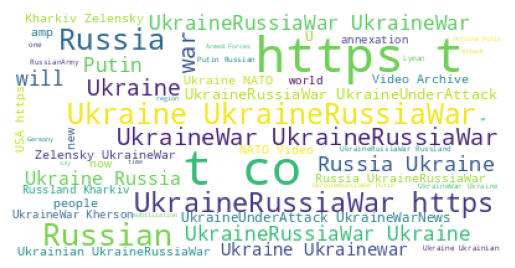

In [23]:
wordcloud = WordCloud(background_color="white",max_font_size=40, relative_scaling=.5).generate(full_text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/WordCloud1.jpg")
plt.show()

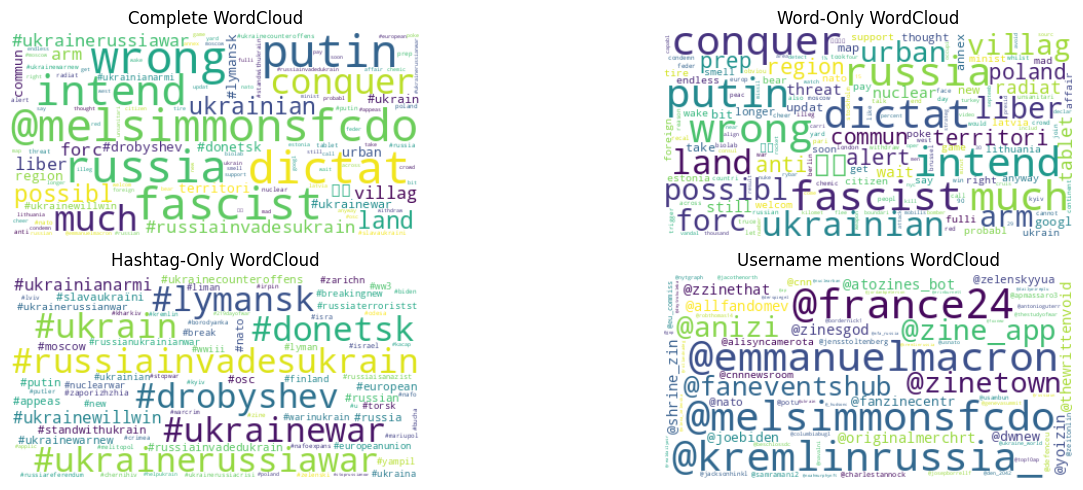

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))

wordcloud_full = WordCloud(background_color="white", max_words=200, width=400, height=200).generate_from_frequencies(vocabulary)
axes[0, 0].imshow(wordcloud_full, interpolation="bilinear")
axes[0, 0].set_title("Complete WordCloud")
axes[0, 0].axis("off")

filtered_vocabulary_words = {word: weight for word, weight in vocabulary.items() if not (word.startswith("#") or word.startswith("@"))}
wordcloud_filtered_words = WordCloud(background_color="white",max_font_size=40, relative_scaling=.5).generate_from_frequencies(filtered_vocabulary_words)
axes[0, 1].imshow(wordcloud_filtered_words, interpolation="bilinear")
axes[0, 1].set_title("Word-Only WordCloud")
axes[0, 1].axis("off")

filtered_vocabulary_hashtags = {key: value for key, value in vocabulary.items() if key.startswith('#')}
wordcloud_hashtags = WordCloud(background_color="white",max_font_size=40, relative_scaling=.5).generate_from_frequencies(filtered_vocabulary_hashtags)
axes[1, 0].imshow(wordcloud_hashtags, interpolation="bilinear")
axes[1, 0].set_title("Hashtag-Only WordCloud")
axes[1, 0].axis("off")

filtered_vocabulary_usernames = {key: value for key, value in vocabulary.items() if key.startswith('@')}
wordcloud_hashtags = WordCloud(background_color="white",max_font_size=40, relative_scaling=.5).generate_from_frequencies(filtered_vocabulary_usernames)
axes[1, 1].imshow(wordcloud_hashtags, interpolation="bilinear")
axes[1, 1].set_title("Username mentions WordCloud")
axes[1, 1].axis("off")

plt.tight_layout()

plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/WordCloud2.jpg")
plt.show()

Average number of tokens / tweet 17.60425


<Figure size 900x600 with 0 Axes>

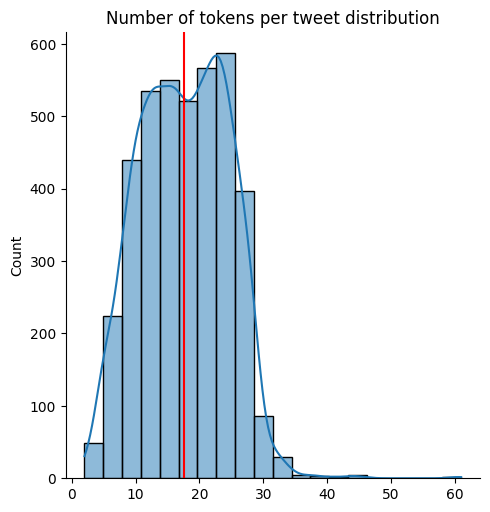

In [37]:
tweet_token_length = []
for t in tweets:
  tweet_token_length.append(len(t.tokenized_text))
avg_token_length = sum(tweet_token_length)/len(tweet_token_length)
print(f"Average number of tokens / tweet {avg_token_length}")
sns.displot(x=tweet_token_length, bins=20, kde=True)
plt.axvline(avg_token_length, color="red")
plt.title("Number of tokens per tweet distribution")
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/tokernsxtweet.jpg", bbox_inches='tight')
plt.show()

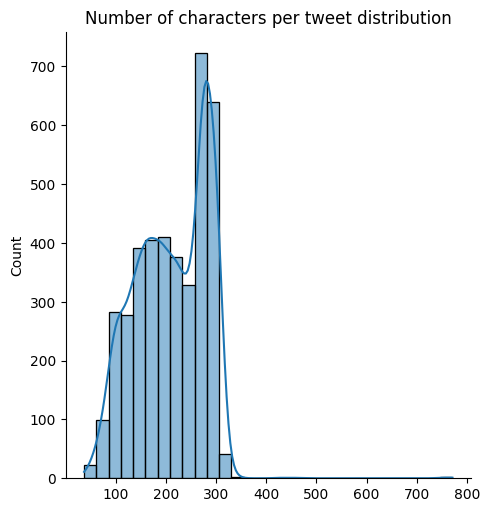

In [40]:
tweet_length = []
for t in tweets: # We append the length of each tweet (before processing)
  tweet_length.append(len(t.text))
sns.displot(x=tweet_length, bins=30, kde=True)
plt.title("Number of characters per tweet distribution")
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/charactersxTweet.jpg", bbox_inches='tight')
plt.show()

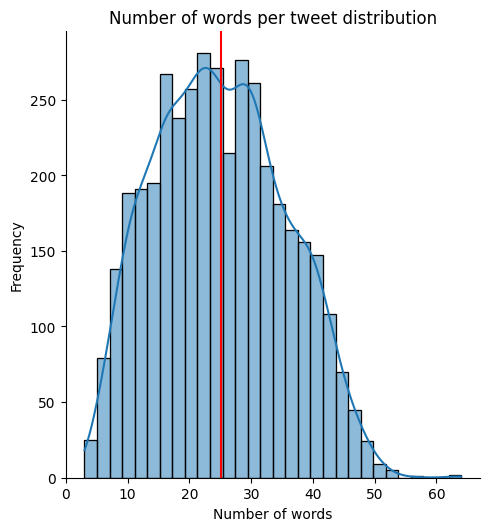

Average tweet lenght (words): 25.0595


In [39]:
word_counts = []
words_list = []

for t in tweets: # We count how many word per tweet there are
    words = t.text.split()
    for w in words:
      words_list.append(w)
    word_count = len(words)
    word_counts.append(word_count)


sns.displot(x=word_counts, bins=30, kde=True)
plt.axvline(len(words_list)/len(tweets), color="red")
plt.title("Number of words per tweet distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/wordsxTweet.jpg", bbox_inches='tight')
plt.show()
print(f"Average tweet lenght (words): {len(words_list)/len(tweets)}")

<ipython-input-29-aef093da394e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df.corr()


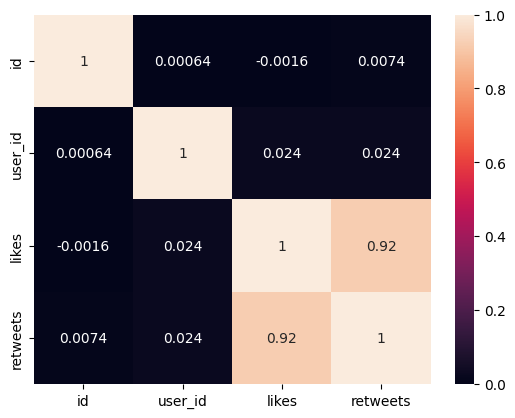

In [29]:
matrix = df.corr()
sns.heatmap(matrix, annot=True)
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/corrMatrix.jpg")
plt.show()

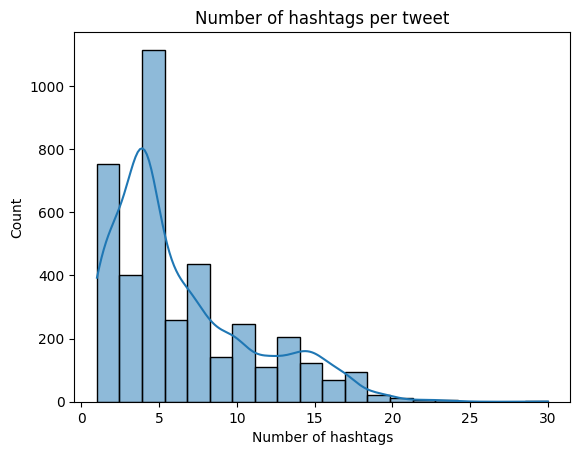

In [38]:
hashtag_count = []
for t in tweets: # We store how many hastags there are per tweet
  hashtag_count.append(len(t.hashtags))

sns.histplot(hashtag_count, bins=20, kde=True)
plt.title("Number of hashtags per tweet")
plt.xlabel("Number of hashtags")
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/hashtagsxTweet.jpg", bbox_inches='tight')
plt.show()

In [16]:
df_sorted = df.sort_values(by="retweets", ascending=False)
df_sorted.head(10)

,id,user_id,username,doc_id,text,tokenized_text,date,hashtags,likes,retweets,url
1219,1575775162674212865,934810674450059265,Militarylandnet,doc_1220,🗺️Situation around Lyman - Sep 30 11:00:\n- UA...,"[situat, around, lyman, sep, 30, 11, 00, ua, f...",2022-09-30 09:10:49+00:00,[UkraineRussiaWar],3701,646,https://www.twitter.com/Militarylandnet/status...
2813,1575396903252025351,934810674450059265,Militarylandnet,doc_2814,📷Unique and rare photos of Ukrainian forward c...,"[uniqu, rare, photo, ukrainian, forward, comma...",2022-09-29 08:07:45+00:00,"[Kharkiv, UkraineRussiaWar]",2685,338,https://www.twitter.com/Militarylandnet/status...
3765,1575181552170201088,934810674450059265,Militarylandnet,doc_3766,📽️Operation Interflex: Ukrainian recruits cont...,"[oper, interflex, ukrainian, recruit, continu,...",2022-09-28 17:52:02+00:00,[UkraineRussiaWar],2155,283,https://www.twitter.com/Militarylandnet/status...
1846,1575625313446289409,1496209819065327624,OSINTschizo,doc_1847,The following countries have urged their citiz...,"[follow, countri, urg, citizen, leav, 🇷🇺, upda...",2022-09-29 23:15:23+00:00,"[UkraineRussiaWar, AnnexationofUkraine, NAFO]",923,251,https://www.twitter.com/OSINTschizo/status/149...
1387,1575742923068813314,934810674450059265,Militarylandnet,doc_1388,📽️Russians shelled the outskirts of #Zaporizhz...,"[russian, shell, outskirt, #zaporizhzhia, hit,...",2022-09-30 07:02:43+00:00,"[Zaporizhzhia, UkraineRussiaWar]",694,247,https://www.twitter.com/Militarylandnet/status...
1209,1575778551248605184,1476814665048997889,CyberMartiansio,doc_1210,The war will not end with the so called annexa...,"[war, end, call, annex, referendum, genuin, ex...",2022-09-30 09:24:17+00:00,"[Ukraine, UkraineRussiaWar, NFTs]",270,236,https://www.twitter.com/CyberMartiansio/status...
1532,1575686562616004609,1517696955329228800,Ukraine66251776,doc_1533,Russia may have dropped 11 meters long X-22 mi...,"[russia, may, drop, 11, meter, long, x, 22, mi...",2022-09-30 03:18:46+00:00,"[Dnipro, NATORussiaWar, UkraineRussiaWar, Kher...",713,184,https://www.twitter.com/Ukraine66251776/status...
205,1575896773511434240,934810674450059265,Militarylandnet,doc_206,📽️🇺🇦 Ukrainian forces liberated Drobysheve in ...,"[🇺🇦, ukrainian, forc, liber, drobyshev, #donet...",2022-09-30 17:14:04+00:00,"[Donetsk, UkraineRussiaWar]",1407,171,https://www.twitter.com/Militarylandnet/status...
2118,1575559188079845376,934810674450059265,Militarylandnet,doc_2119,"🗞️Kostyantyn Nemichev, the commander of Kraken...","[kostyantyn, nemichev, command, kraken, specia...",2022-09-29 18:52:37+00:00,[UkraineRussiaWar],1407,136,https://www.twitter.com/Militarylandnet/status...
3801,1575178643772297216,934810674450059265,Militarylandnet,doc_3802,📽️Ukrainian paratroopers on BTR-3 during the o...,"[ukrainian, paratroop, btr, 3, offens, #kharki...",2022-09-28 17:40:28+00:00,"[Kharkiv, Donetsk, UkraineRussiaWar]",1348,133,https://www.twitter.com/Militarylandnet/status...


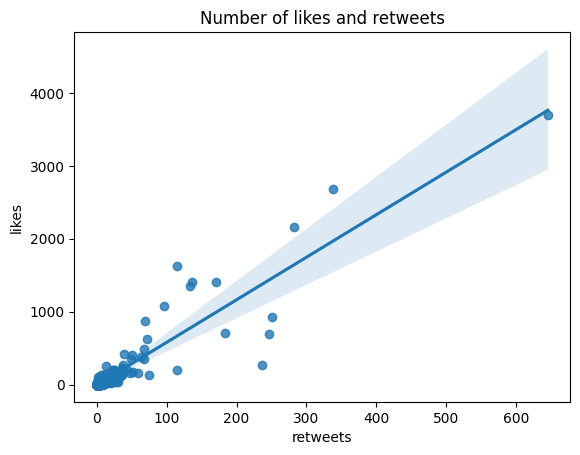

In [31]:
plt.title("Number of likes and retweets")
sns.regplot(df, x="retweets", y="likes" )
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/NumLikesRetweets.jpg")
plt.show()

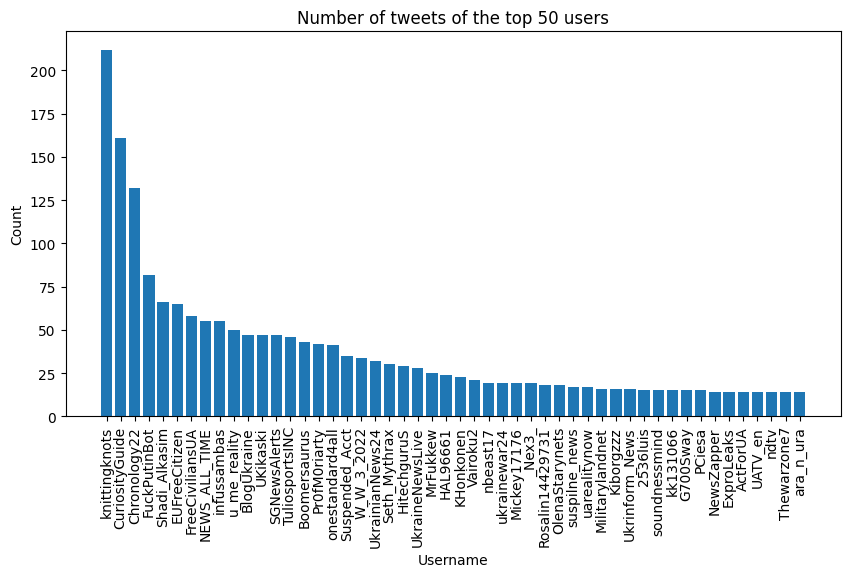

In [42]:
usernames = {}
for t in tweets: # We count how many tweets has each user done
  if t.username not in usernames.keys():
    usernames[t.username] = 1
  else:
    usernames[t.username] += 1

top_50 = {k: v for k, v in sorted(usernames.items(), key=lambda item: item[1], reverse=True)}
top_50 = {k: top_50[k] for k in list(top_50.keys())[:50]} # We take the top 50
plt.figure(figsize=[10,5])
plt.title("Number of tweets of the top 50 users")
plt.xlabel("Username")
plt.ylabel("Count")
plt.bar(top_50.keys(), top_50.values())
plt.xticks(rotation=90)
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/tweetsTop50.jpg", bbox_inches='tight')
plt.show()

In [19]:
bot_users = set()
for t in tweets: # We check if there are bots
    find = re.search("bot", t.username.lower())
    if find != None:
      bot_users.add(t.username)
print(f"Candidate bot users: {bot_users}")

Candidate bot users: {'BottomerEileen', 'FuckPutinBot'}


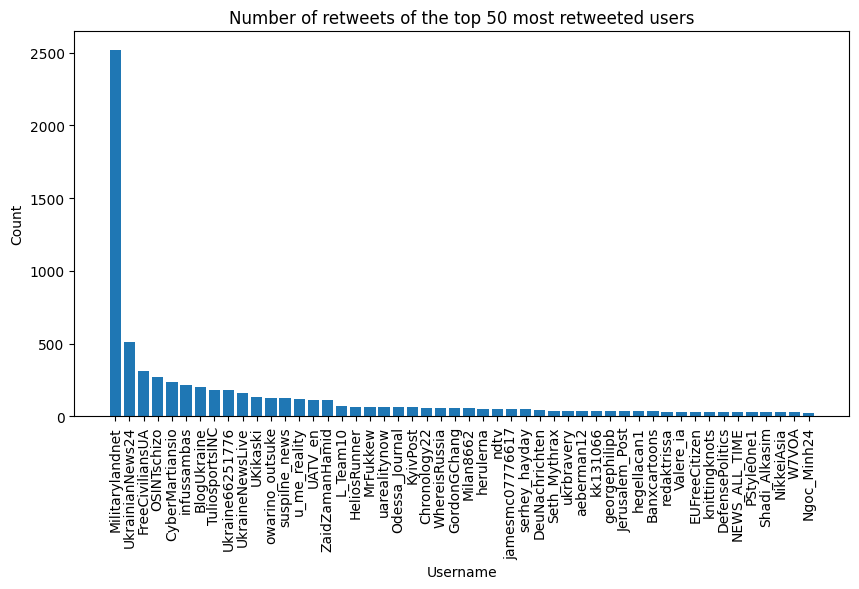

In [41]:
retweets_user = {}
for t in tweets: # We store how many retweets has each user in their tweets
  if t.username not in retweets_user.keys():
    retweets_user[t.username] = t.retweets
  else:
    retweets_user[t.username] += t.retweets

top_50 = {k: v for k, v in sorted(retweets_user.items(), key=lambda item: item[1], reverse=True)}
top_50 = {k: top_50[k] for k in list(top_50.keys())[:50]}
plt.figure(figsize=[10,5])
plt.title("Number of retweets of the top 50 most retweeted users")
plt.xlabel("Username")
plt.ylabel("Count")
plt.bar(top_50.keys(), top_50.values())
plt.xticks(rotation=90)
plt.savefig("/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/plots/retweetsTop50.jpg", bbox_inches='tight')
plt.show()